# Hair Removal

Import librairies 

In [1]:
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from math import sqrt
import copy
import scipy
from scipy import signal

### Fonctions auxiliaires

In [2]:
def load_image(path) : # Charge une image en RGB au lieu de BGR
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return(img)

def show_image(img) : # Affiche l'iamge depuis la matrice
    cv2.imshow('image', img) 
    
    

### Transformations de l'espace de couleur 

In [3]:
def RGB2XYZ(img) : # Transformation dans l'espace XYZ avec la nrome D65
    imgXYZ = cv2.cvtColor(img, cv2.COLOR_RGB2XYZ)
    return(imgXYZ)

def RGB2Gray(img) : # RGB vers niveaux de gris 
    imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return(imgGray)

### Noyaux de détection pour fermeture morphologique

L'objectif est de créer des noyaux dans le plus de directions possibles afin de détecter un maximum de poils d'orientations différentes

In [4]:
def horizontalKernel(size) : # Noyau horizontal de taille size*size
    if (size % 2 == 0) :
        print("Size must be an odd number")
        return() 
    kernel = np.zeros( (size, size),np.uint8 )
    mid = size//2
    kernel[mid] = np.array([1 for i in range(size)])
    return(kernel)

horizontalKernel(5)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [5]:
def verticalKernel(size) : # Noyau vertical
    if (size % 2 == 0) :
        print("Size must be an odd number")
        return()
    kernel = np.zeros( (size, size), np.uint8 )
    mid = size//2
    for i in range(size) :
        kernel[i, mid] = 1
    return(kernel)

verticalKernel(5)

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [6]:
def diagLKernel(size) : # Noyau vertical gauche (L), matrice identité
    kernel = np.identity(size, np.uint8)
    return(kernel)

diagLKernel(5)

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [7]:
def diagRKernel(size) : # Noyau verticaldroit (R)
    kernel = np.zeros( (size, size), np.uint8 )
    for i in range(size) :
        kernel[i, size-i-1] = 1
    return(kernel)

diagRKernel(5)

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=uint8)

In [8]:
def kernel135R(size) : # Noyau avec angle de 135° à droite (R)
    kernel = np.zeros( (size, size), np.uint8 )
    if (size%2 == 0) : ## Si la taille de la matrie est paire
        mid = size // 2
        count = 0
        x0 = mid 
        y0 = mid-1
        x1 = mid-1
        y1 = mid 
        while ( (x1 >= 0) and (x0 <= size) and (y1 <= size) and (y0 >= 0) ) :
            kernel[x0, y0] = 1
            kernel[x1, y1] = 1
            y1 += +1
            y0 += -1
            count += 1
            if (count == 2) :
                count = 0
                x1 += -1
                x0 += +1
        return(kernel)
    else :            ## Si la taille de la matrice est impaire
        mid = size // 2
        count = 0
        x0 = mid 
        y0 = mid
        x1 = mid
        y1 = mid 
        while ( (x1 >= 0) and (x0 <= size) and (y1 <= size) and (y0 >= 0) ) :
            kernel[x0, y0] = 1
            kernel[x1, y1] = 1
            y1 += +1
            y0 += -1
            count += 1
            if (count == 2) :
                count = 0
                x1 += -1
                x0 += +1
        return(kernel)

print(kernel135R(6), '\n')
print(kernel135R(7))

[[0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 1 1 0]
 [0 1 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]] 

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1]
 [0 0 1 1 1 0 0]
 [1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [9]:
def kernel135L(size) : # Noyau avec angle de 135° à gauche (L)
    kernel = np.zeros( (size, size), np.uint8 )
    if (size%2 == 0) : ## Si la taille de la matrie est paire
        mid = size // 2
        count = 0
        x1 = mid
        y1 = mid
        x0 = mid - 1
        y0 = mid-1
        while ( (x0 >= 0) and (x1 <= size) and (y1 <= size) and (y0 >= 0) ) :
            kernel[x0, y0] = 1
            kernel[x1, y1] = 1
            y1 += +1
            y0 += -1
            count += 1
            if (count == 2) :
                count = 0
                x1 += 1
                x0 += -1
        return(kernel)
    else :            ## Si la taille de la matrice est impaire
        mid = size // 2
        count = 0
        x0 = mid 
        y0 = mid
        x1 = mid
        y1 = mid 
        while ( (x1 >= 0) and (x0 <= size) and (y1 <= size) and (y0 >= 0) ) :
            kernel[x0, y0] = 1
            kernel[x1, y1] = 1
            y1 += +1
            y0 += -1
            count += 1
            if (count == 2) :
                count = 0
                x1 += 1
                x0 += -1
        return(kernel)

print(kernel135L(6), '\n')
print(kernel135L(7))


[[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 1 0 0 0]
 [0 0 0 1 1 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]] 

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


### Fermetures morphologiques 

Application de fermetures morphologiques pour chacun des 256 seuillages bianires avec un noyau donné. L'image est ensuite recosntruite en niveaux de gris. La fermeture morphologique consiste en l'application d'une dilatation suivie d'une érosion. 

In [10]:
def closing(kernel, imGray) : # Fermeture morphologique avec openCV. L'mage doit être en nvieaux de gris !
    if (len(imGray.shape) != 2) :
        print("L'image doit être en niveaux de gris")
        return()
    clos = cv2.morphologyEx(imGray,cv2.MORPH_CLOSE, kernel)
    return(clos)

Testons la fermeture sur une image en appliquant tour à tour chacun des noyaux. On essaiera plus tard d'optimsier les paramètres. Par exemple en faisant grandir la taille des noyax dans une boucle for ou en modifiant l'ordre des noyaux.

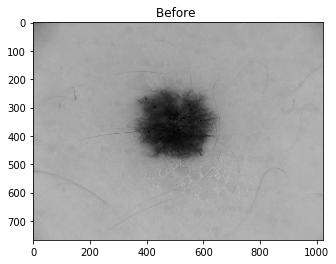

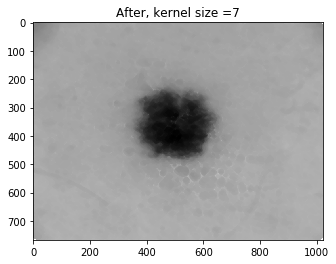

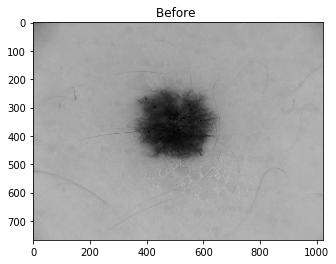

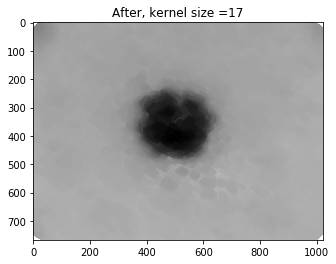

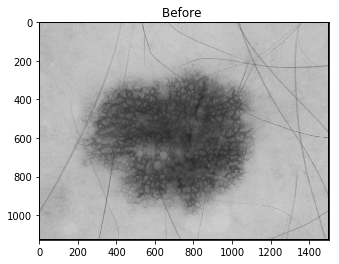

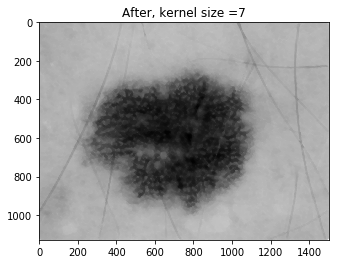

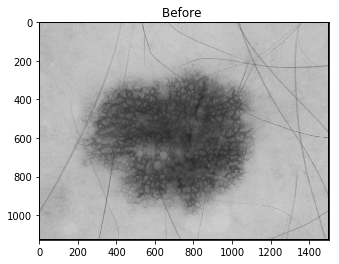

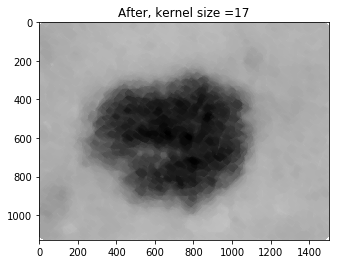

In [11]:
####Tests
def successiveKernels(img, size) : # Applique successivement les différents noyaux de fermeture
    clos = RGB2Gray(img)

    kernel = horizontalKernel(size)
    clos = closing(kernel, clos)

    kernel = verticalKernel(size)
    clos = closing(kernel, clos)

    kernel = diagRKernel(size)
    clos = closing(kernel, clos)

    kernel = diagLKernel(size)
    clos = closing(kernel, clos)

    kerenl = kernel135R(size)
    clos = closing(kernel, clos)

    kernel = kernel135L(size)
    clos = closing(kernel, clos)
    
    return(clos)


def testClosing(size, path) :    
    img = load_image(path)
    clos = successiveKernels(img, size)
    plt.imshow(RGB2Gray(img), cmap = 'gray')
    plt.title('Before ')
    plt.show()
    plt.imshow(clos, cmap = 'gray')
    plt.title('After, kernel size =' + str(size))
    plt.show()

path = 'nevus/ISIC_0000001.jpg'
testClosing(7, path)
testClosing(17, path)

path = 'nevus/ISIC_0000019.jpg'
testClosing(7, path)
testClosing(17, path)


Il y a donc un compris à avoir entre la simplification de forme qui ne doit pas être trop importante et l'efficacité de la suppression de poils. On remarque égalament que, pour les poils épais, la taille doit être plus importante. Il faudrait donc faire au cas par cas et ajuster la taille des noyaux pour chaque image.


### Création du masque pour la suppression 

Trouver les positions des poils à partir des opérations de fermeture pour ensuite les supprimer de l'image d'origine.

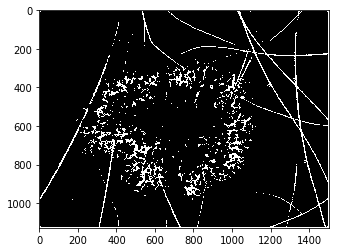

In [12]:
def createMask(img) : # Creér un masque qui localise les poils
    clos = successiveKernels(img, 17)
    imGray = RGB2Gray(img)
    diff = clos - imGray
    th , mask = cv2.threshold(diff, 19, 1, cv2.THRESH_BINARY);
    return(mask)
    
path = 'nevus/ISIC_0000019.jpg'
img = load_image(path)
mask = createMask(img)
cv2.imwrite('mask.jpg', mask)
plt.imshow(mask, cmap = 'gray')

On pourrait retirer les petites composantes connexes pour ne garder que les poils. A faire.

Utiliser kmeans pour le seuillage ??????

### Remplace les pixels supprimés par interpolation 

La difficulté tient du fait que certains poils étant épais, il est nécessaire de prendre une fenêtre relativement large pour l'interpolation. 

In [13]:
def removeHair(img, mask) : # Mets les pixels supprimés à la valeur 0 pour ne pas influencer l'interpolation
    img1 = np.copy(img)
    for i in range(len(img)) :
        for j in range(len(img[0])) :
            if (mask[i, j] == 1) :
                img1[i, j, 0] = 0
                img1[i, j, 1] = 0
                img1[i, j, 2] = 0
            
    return(img1)


def bicubicInterpolation(img1, i, j, mask) : # Interpolation bicubique sur une fenêtre de taille 'taille'
    taille = 9
    count_non_mask = 0
    value = np.array([0 ,0 ,0])
    for di in range(-taille, taille + 1) :
        for dj in range(-taille, taille + 1) :
            if (mask[i + di, j + dj] != 1) :
                count_non_mask += 1
                value = value + img1[i + di, j + dj]
    if (count_non_mask == 0) : # évite les divisions par 0
        return(value)
    else :
        return((1/count_non_mask)*value)
    

def interpoleImage(img1, mask) : # Application de l'itnerpolation à chacun des pixels précédemment supprimés
    taille = 9
    for i in range(taille, len(img1) - taille) :
        for j in range(taille, len(img1[0]) - taille) :
            if (mask[i, j] == 1) :
                img1[i,j] = bicubicInterpolation(img1, i, j, mask)
    return(img1)

Testons l'interpolation avant application d'un filtre médian 

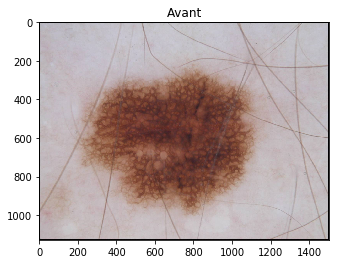

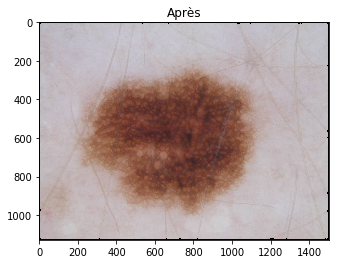

In [14]:
path = 'nevus/ISIC_0000019.jpg'
img = load_image(path)
mask = createMask(img)
img1 = removeHair(img, mask)
img1 = interpoleImage(img1, mask)

plt.imshow(img)
plt.title('Avant')
plt.show()
plt.imshow(img1)
plt.title('Après')
plt.show()

### Filtrage médian

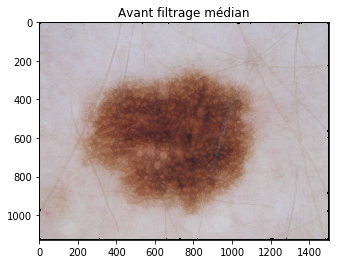

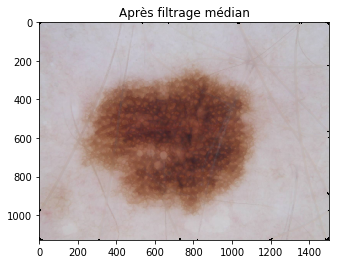

In [15]:
'''path = 'nevus/ISIC_0000019.jpg'
img = load_image(path)
mask = createMask(img)
img1 = removeHair(img, mask)
img1 = interpoleImage(img1, mask)'''

## Filtrage médian avec openCV
median = cv2.medianBlur(img1,7)

plt.imshow(img1)
plt.title('Avant filtrage médian')
plt.show()
plt.imshow(median)
plt.title('Après filtrage médian')
plt.show()

### Fonction globale

In [16]:
def globalRemoveHair(path) : # Fonction globale qui applique et affic
    img = load_image(path)
    mask = createMask(img)
    img1 = removeHair(img, mask)
    img1 = interpoleImage(img1, mask)
    final = cv2.medianBlur(img1,7)
    return(img, final)
 

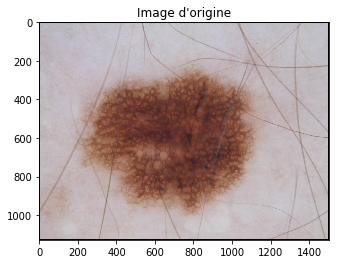

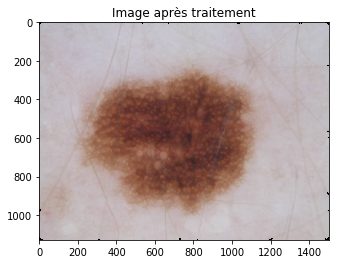

In [17]:
glob = globalRemoveHair(path = 'nevus/ISIC_0000019.jpg')
img = glob[0]
final = glob[1]

plt.imshow(img)
plt.title("Image d'origine")
plt.show()
plt.imshow(final)
plt.title("Image après traitement")
plt.show()